This notebook should predict WB_sg from 9 input features.

Andrew Fagerheim and Bernard Wang

In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-12-21 20:28:29.096140: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 20:28:29.145950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
input_features = ['grad_B','FCOR', 'HML', 'Nsquared', 'Q', 'TAU', 'HBL', 'strain', 'vort', 'div']
# 0. Depth-averaged buoyancy gradient magnitude
# 1. Coriolis parameter
# 2. Mixed layer depth
# 3. Brunt-Vaisala frequency
# 4. Surface heat flux
# 5. Surface wind stress magnitude
# 6. Boundary layer depth
# 7. Depth-averaged strain magnitude
# 8. Depth-averaged vertical vorticity
# 9. Depth-averaged horizontal divergence
output_feature = 'WB_sg'
# 10. Depth-averaged vertical bouyancy flux

# Things about the data and model we are learning:
- There are 10 input features, 1 output feature.
- 12 locations, each with 846 time ticks. 14 months, September 2011 to November 2012 it seems. Indices 0-845 is one location. Then 846-846+845 is another location.
- Seems like there are two roughly two time ticks per day. 2/day __makes sense?__
- They are 40 by 40 boxes. they have lat/lon of 15x15 boxes by the way. Paper says it has been coarsened to 1/4 degree grid.  __makes sense?__
- would it be helpful to have the actual latitude and longitudes? or does it not matter? i'm cool with not having em..
  - but, we want to weigh our data, no?? without lat, we don't weight our data properly......
  - features are allegedly normalized by their regional mean and standard deviation. again, do we want to weigh our data with latitude?
- Model selects 80% of the 10,152 samples from all regions combined to TRAIN. Selects the remaining 20% to test, and compare with the target LLC4320 data.
- the CNN/NN example notebooks use CO2 and CH4, which only have one value per time tick, rather than one for each lat/lon pair. So, they are 1-D time series rather than 3-D time series. Here, we have 3-D time series used to train. Have to figure out how to shove that data into the model.
- Also have to figure out how to concatenate all the different locations' data and put into the model. How do they get added in? __figure this out__

# We are gonna just use all 10152 time indices. All 846 time indices for 12 locations.

#### Load and normalize Input

In [3]:
# load input. (We gonna look at all 10152 time indices)

# 1. Create xarray dataset, populate it with the numpy files but turn them into dataarrays.
X_xr = xr.Dataset()
X_xr_og = xr.Dataset()
for input_feature in input_features:
    var = np.load('data/%s.npy' % input_feature)
    var_xr = xr.DataArray(var, coords={'time': np.arange(0, len(var)),'lat': np.arange(0, 40),'lon': np.arange(0, 40)}, dims=["time", "lat", "lon"])
    X_xr_og[input_feature] = var_xr #unnormalized
    X_xr[input_feature] = (var_xr - var_xr.mean()) / var_xr.std() #normalized
    
# X_xr: normalized.
# X_xr_og: not normalized.

In [4]:
X_xr

<xarray.Dataset>
Dimensions:   (time: 10152, lat: 40, lon: 40)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 ... 10146 10147 10148 10149 10150 10151
  * lat       (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * lon       (lon) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
Data variables:
    grad_B    (time, lat, lon) float64 -0.5969 -0.5104 ... -0.3318 0.5773
    FCOR      (time, lat, lon) float64 0.3344 0.3344 0.3344 ... -0.1989 -0.1989
    HML       (time, lat, lon) float64 0.2489 0.2642 0.2574 ... 0.424 0.3288
    Nsquared  (time, lat, lon) float64 -0.2498 -0.2447 ... -0.3052 -0.2827
    Q         (time, lat, lon) float64 -0.8277 -0.816 ... -0.4634 -0.5633
    TAU       (time, lat, lon) float64 -0.5077 -0.5075 -0.5202 ... 0.6422 0.6074
    HBL       (time, lat, lon) float64 -0.305 -0.3105 -0.3083 ... -0.326 -0.2534
    strain    (time, lat, lon) float64 -0.474 -0.7203 ... -0.4636 -0.1761
    vort      (time, lat, lon) float64 -0.1777 0.08519 0.2384 ... 0.8995 0.8972
    div       (time, lat, lon) float64 0.2915 0.04385 0.309 ... 0.3343 -0.3322

In [5]:
# Determine the random part of the dataset that will be training data, and the other part will be testing data.
train_split = 0.8

time_indices = len(X_xr.time)
train_cutoff = round(train_split*time_indices)
rand_indices = np.arange(time_indices)
np.random.shuffle(rand_indices)

# THESE INDICES WILL BE USED FOR BOTH THE INPUT AND OUTPUT.
train_indices = rand_indices[:train_cutoff]
test_indices = rand_indices[train_cutoff:]

In [6]:
# Train indices: random 80% of the data. Test indices: random 20% of the data.
X_train_xr = X_xr.isel(time=train_indices)
X_test_xr = X_xr.isel(time=test_indices)


#### Load and normalize output

In [7]:
# 1. load WB_sg numpy file from data.
# Vertical Buoyancy Flux
WB_sg = np.load('data/WB_sg.npy')
# 2. turn the data into an xarray dataarray
WB_sg_xr_og = xr.DataArray(WB_sg, coords={'time': np.arange(0, len(WB_sg)),'lat': np.arange(0, 40),'lon': np.arange(0, 40)}, dims=["time", "lat", "lon"])
WB_sg_xr = (WB_sg_xr_og - WB_sg_xr_og.mean()) / WB_sg_xr_og.std()

# training:
y_train_xr = WB_sg_xr.isel(time=train_indices)
y_train_np = y_train_xr.data

# we will save y_test_xr, and y_test_og_xr as nc files. y_test_xr is normalized, y_test_og_xr is not normalized.
y_test_xr = WB_sg_xr.isel(time=test_indices)
y_test_np = y_test_xr.data
y_test_og_xr = WB_sg_xr_og.isel(time=test_indices)

In [8]:
X_train_np = X_train_xr.to_array().transpose('time', 'lat', 'lon', 'variable').data
X_test_np  = X_test_xr.to_array().transpose('time', 'lat', 'lon', 'variable').data
lat, lon, num_inputs = X_train_np.shape[1:]

print(X_train_np.shape,y_train_np.shape,X_test_np.shape,y_test_np.shape)

(8122, 40, 40, 10) (8122, 40, 40) (2030, 40, 40, 10) (2030, 40, 40)


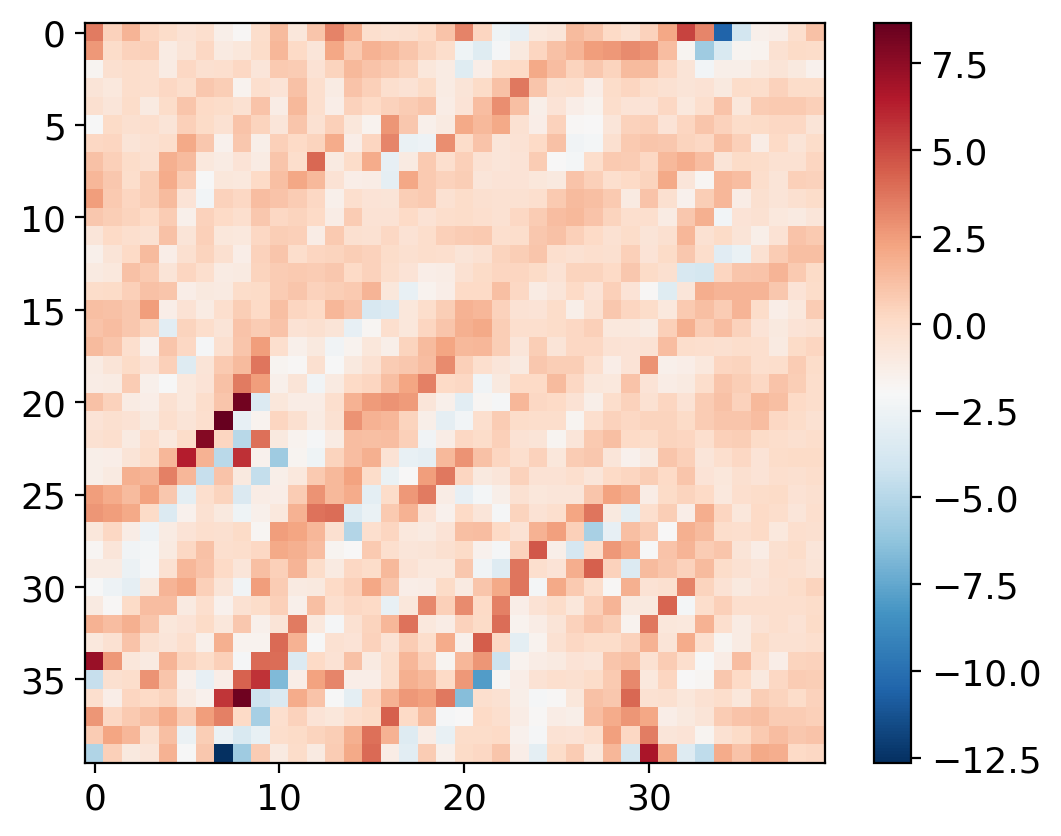

In [9]:
# Still ordered WB_sg_xr
# plt.imshow(np.flip(WB_sg_xr.data[1],axis=0),cmap='RdBu_r')
plt.imshow(np.flip(X_train_xr['div'].isel(time=1).data, axis=0), cmap='RdBu_r')

# Randomized order, 80% of WB_sg_xr. aka y_train
#plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r')
plt.colorbar()

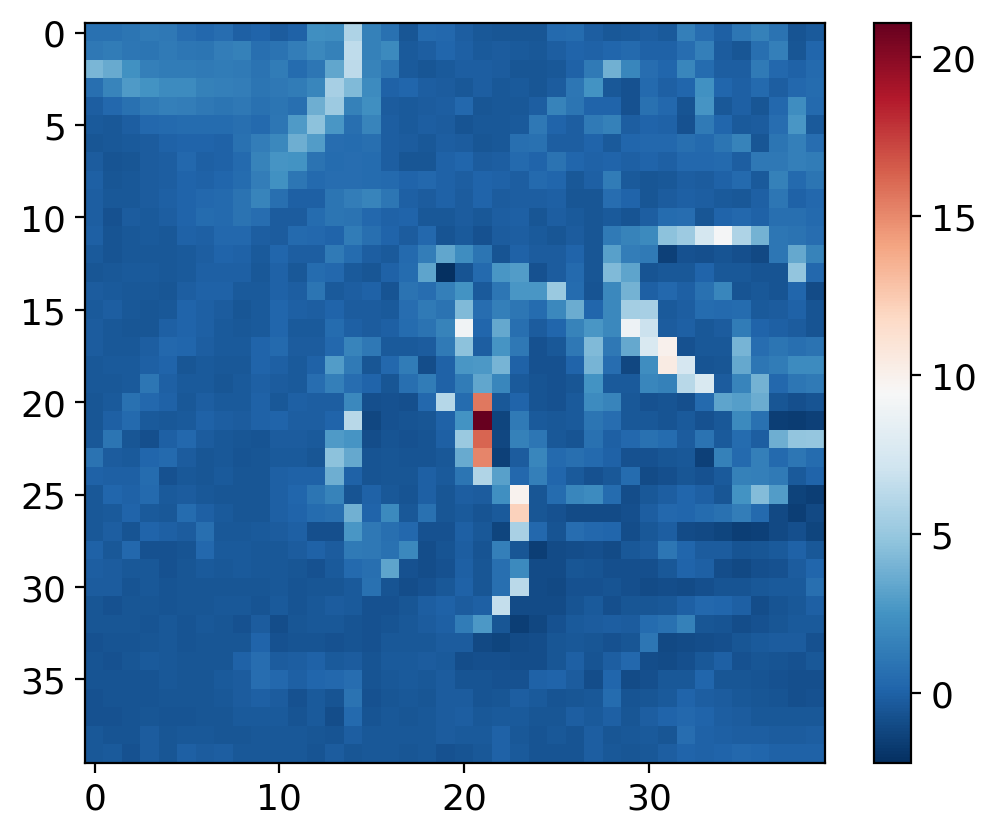

In [105]:
# looking at a still ordered, non-normalized WB_sg_xr
plt.imshow(np.flip(WB_sg_xr.data[2],axis=0),cmap='RdBu_r')

# Randomized order, 80% of WB_sg_xr. aka y_train
#plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r')
plt.colorbar()

## Define CNN Structure

In [12]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 5
hidden_kernel_size = 3
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100

In [13]:
print('X_train_np shape:')
print('\t',X_train_np.shape)
# (8122, 40, 40, 10)
# input wants to be (batch_size, height, width, channels) so I think this is fine.
# There should be 10 (or however many variables we want to use) input channels.
# There should be 1 output channel: the WB_sg variable.
input_shape = X_train_np.shape[1:]
print('input shape into model:')
print('\t',input_shape)

X_train_np shape:
	 (8122, 40, 40, 10)
input shape into model:
	 (40, 40, 10)


In [ ]:
# ### model using MSE as loss function
# # FIGURING OUT TO SHOVE THE X_TRAIN_NP AND Y_TRAIN_NP INTO THIS MODEL.

# model_mse = Sequential()

# #Hmm. The amount of layers is also something to consider, yeah? Like Abigail's..
# model_mse.add(Conv2D(filters=128, kernel_size = kernel_size, input_shape = X_train_np.shape[1:],
#                     activation=activation, padding='same'))
# model_mse.add(BatchNormalization())
# model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
#                      activation = activation, padding='same'))
# model_mse.add(BatchNormalization())
# model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
#                      activation = 'linear', padding='same'))
# model_mse.add(BatchNormalization())
# model_mse.add(Conv2D(filters=1, kernel_size = hidden_kernel_size,
#                      activation = 'linear', padding='same'))

# #pytorch got some batchnorm2d(out_channels) bullshit.
# # keep lookin at the damn keras conv2D and FIGURE OUT WHAT IS GOIN ON.

# # FULLY CONVOLUTIONAL NEURAL NETWORK. DENSE LAYER IS NOT IMPLEMENTED.
# # we don't want to fix the size of the input, which is what the dense layer does. fully convolution: easily translates to other

# model_mse.summary()
# model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


In [103]:
### model using MSE as loss function
# FIGURING OUT TO SHOVE THE X_TRAIN_NP AND Y_TRAIN_NP INTO THIS MODEL.

model_mse = Sequential()

#Hmm. The amount of layers is also something to consider, yeah? Like Abigail's..
model_mse.add(Conv2D(filters=128, kernel_size = kernel_size, input_shape = X_train_np.shape[1:],
                    activation=activation, padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
                     activation = activation, padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=1, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))

#pytorch got some batchnorm2d(out_channels) bullshit.
# keep lookin at the damn keras conv2D and FIGURE OUT WHAT IS GOIN ON.

# FULLY CONVOLUTIONAL NEURAL NETWORK. DENSE LAYER IS NOT IMPLEMENTED.
# we don't want to fix the size of the input, which is what the dense layer does. fully convolution: easily translates to other

model_mse.summary()
model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 40, 40, 128)       32128     
                                                                 
 batch_normalization_10 (Bat  (None, 40, 40, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 64)        73792     
                                                                 
 batch_normalization_11 (Bat  (None, 40, 40, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 40, 40, 32)        18464     
                                                                 
 batch_normalization_12 (Bat  (None, 40, 40, 32)      

## Train da model

In [104]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

###------------mse------------
history_mse = model_mse.fit(X_train_np, y_train_np, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/100
102/102 [==============================] - 40s 382ms/step - loss: 0.6720 - val_loss: 0.8679
Epoch 2/100
102/102 [==============================] - 39s 382ms/step - loss: 0.5176 - val_loss: 0.6200
Epoch 3/100
102/102 [==============================] - 39s 382ms/step - loss: 0.4732 - val_loss: 0.5762
Epoch 4/100
102/102 [==============================] - 39s 381ms/step - loss: 0.4556 - val_loss: 0.4863
Epoch 5/100
102/102 [==============================] - 39s 383ms/step - loss: 0.4341 - val_loss: 0.4562
Epoch 6/100
102/102 [==============================] - 39s 383ms/step - loss: 0.4263 - val_loss: 0.4284
Epoch 7/100
102/102 [==============================] - 39s 384ms/step - loss: 0.4061 - val_loss: 0.4251
Epoch 8/100
102/102 [==============================] - 39s 383ms/step - loss: 0.4028 - val_loss: 0.3977
Epoch 9/100
102/102 [==============================] - 39s 382ms/step - loss: 0.3830 - val_loss: 0.3879
Epoch 10/100
102/102 [==============================] - 39s 383m

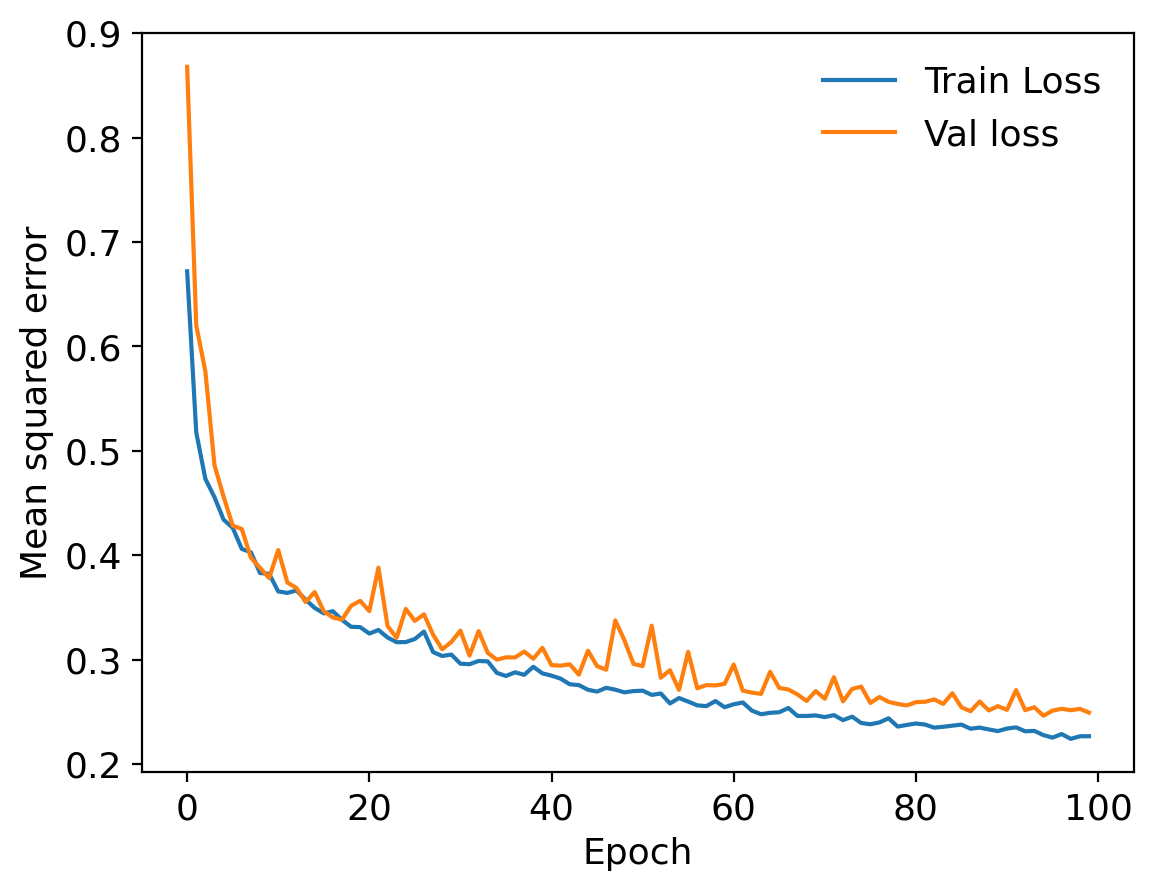

In [107]:
plot_history(history_mse)
# 8 layers, should be basically abigail's recreation.

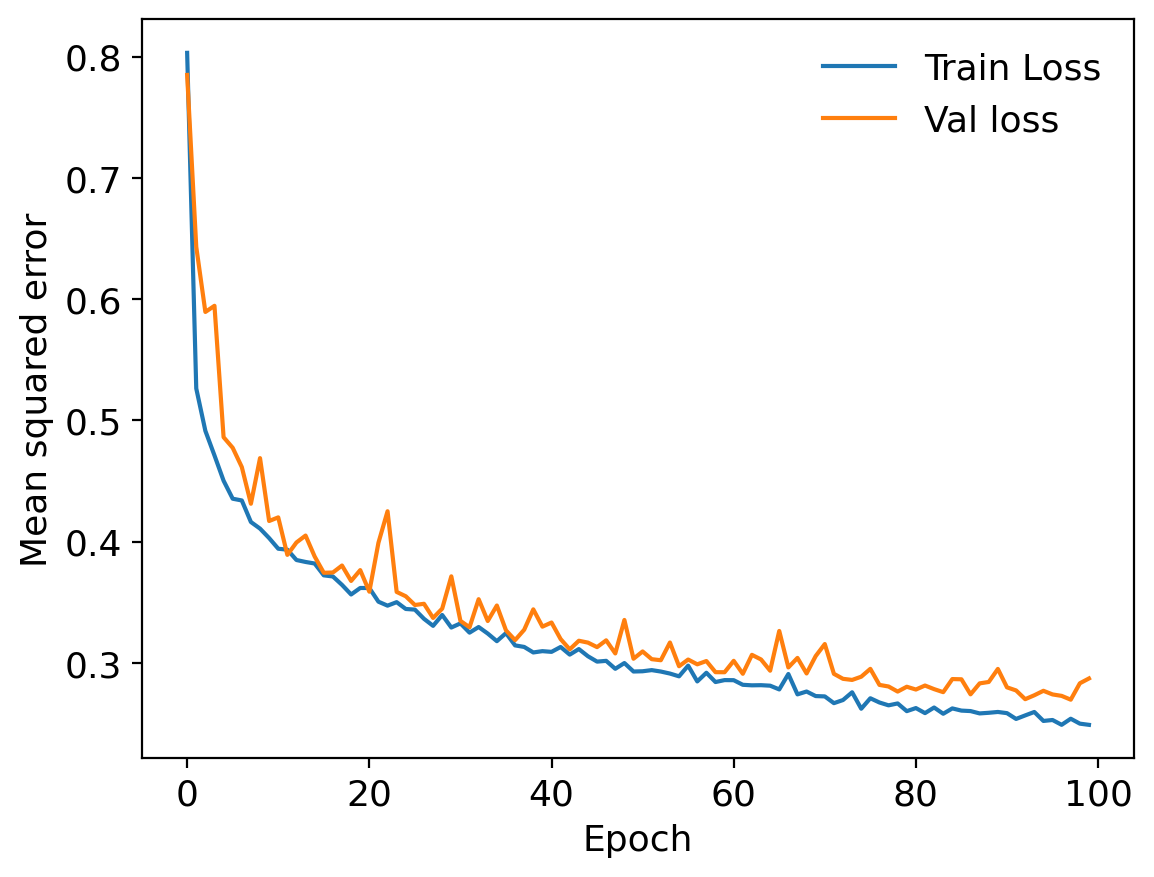

In [22]:
plot_history(history_mse)
# four layers

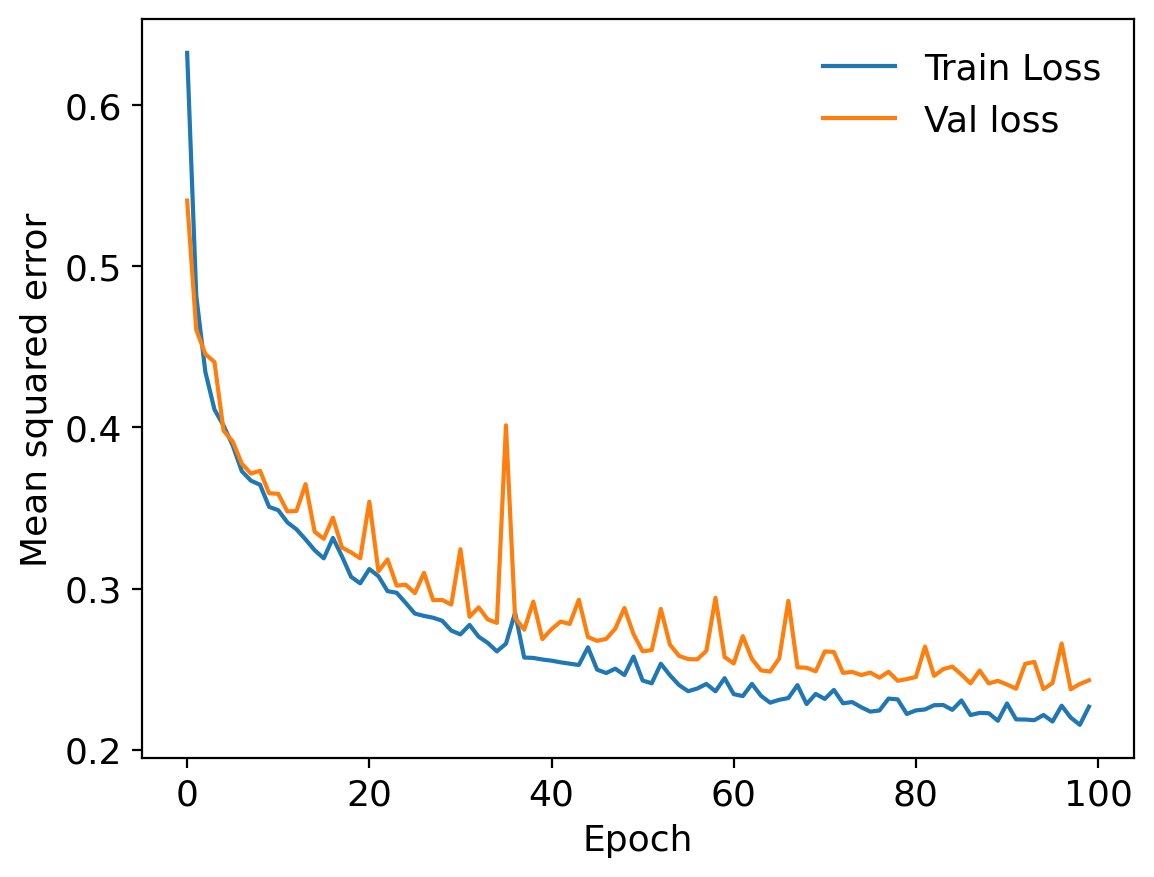

In [41]:
plot_history(history_mse)

In [138]:
history_mse

In [23]:
model_path = os.path.join(cwd,'model')
make_dir(model_path)

### Save your model, and your testing data files.

In [64]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_mse.save(os.path.join(model_path,'CNN_model_mse.h5'))
# we should save the testing data too right? Save y_test_xr here.
y_test_xr.to_netcdf(os.path.join(model_path,'y_test.nc'))
y_test_og_xr.to_netcdf(os.path.join(model_path,'y_test_og.nc'))
WB_sg_xr_og.to_netcdf(os.path.join(model_path,'WB_sg.nc'))

# Evaluate da Trained Model

In [94]:
# reload the saved model
model_mse = load_model(os.path.join(model_path,'CNN_model_mse.h5'))

In [95]:
y_test_mse_pre = model_mse.predict(X_test_np)
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 40, 40)
y_test_mse_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'lat': X_test_xr.lat.values, 
                               'lon': X_test_xr.lon.values},
                       data_vars=dict(WB_sg_normalized=(['time', 'lat', 'lon'], y_test_mse_pre)))

64/64 [==============================] - 3s 44ms/step


In [96]:
# reload the actual test data, get mean and std
y_test_og_xr = xr.open_dataarray(os.path.join(model_path,'y_test_og.nc'))
y_test_xr = xr.open_dataarray(os.path.join(model_path,'y_test.nc'))

WB_sg_og_xr = xr.open_dataarray(os.path.join(model_path,'WB_sg.nc'))
mean = WB_sg_og_xr.mean()
std = WB_sg_og_xr.std()

# scale up the model
y_test_mse_pre['WB_sg_og'] = y_test_mse_pre.WB_sg_normalized * std + mean

In [141]:
# PUT THIS SHIT BACK IN LOCATION BASED AND CHRONOLOGICAL ORDER I GUESS.

In [97]:
y_test_mse_pre

<xarray.Dataset>
Dimensions:           (time: 2030, lat: 40, lon: 40)
Coordinates:
  * time              (time) int64 8300 10057 7768 148 ... 7526 689 5034 5602
  * lat               (lat) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
  * lon               (lon) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
Data variables:
    WB_sg_normalized  (time, lat, lon) float32 0.1996 -0.06808 ... -0.3319
    WB_sg_og          (time, lat, lon) float64 7.865e-09 4.975e-09 ... 2.128e-09

In [98]:
y_test_og_xr

<xarray.DataArray (time: 2030, lat: 40, lon: 40)>
[3248000 values with dtype=float64]
Coordinates:
  * time     (time) int64 8300 10057 7768 148 2236 ... 8470 7526 689 5034 5602
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39

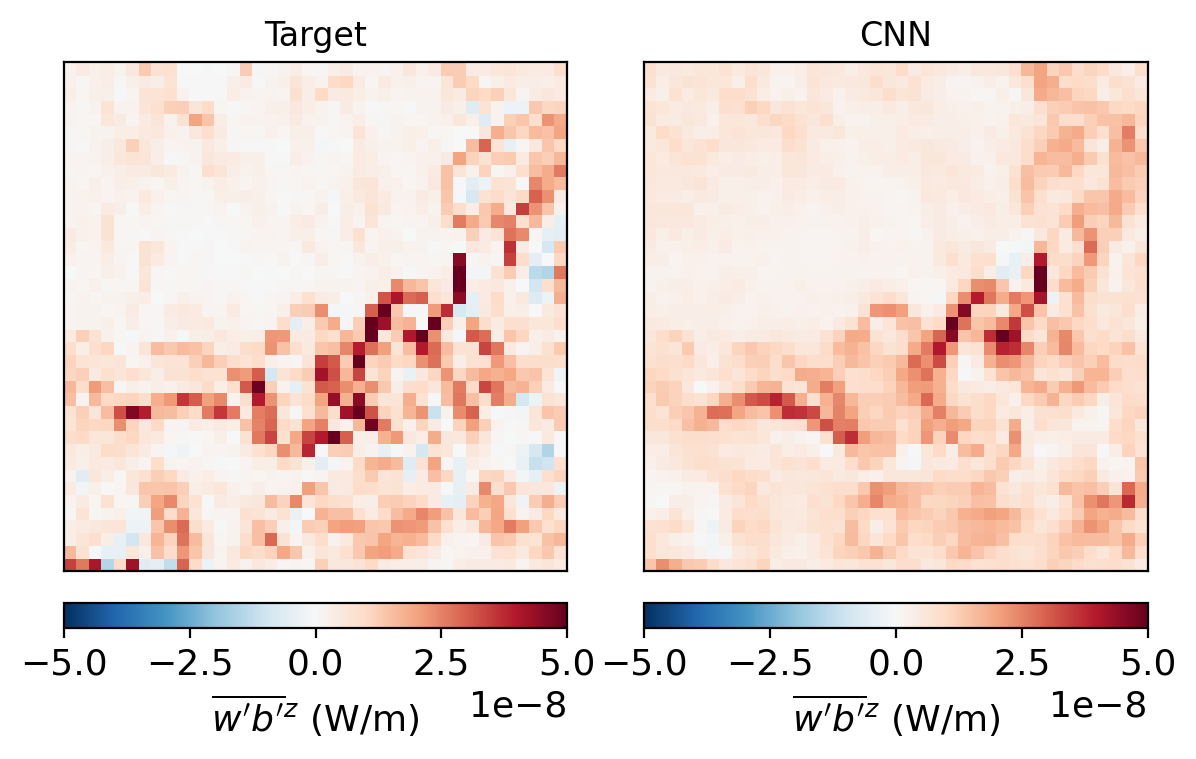

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,4))

ind=0
clim = 5e-8

target_map = y_test_og_xr[ind]
predicted_map = y_test_mse_pre.WB_sg_og[ind]

plt.subplot(1, 2, 1)
plt.pcolor(np.flip(target_map, axis=0),cmap='RdBu_r',vmin=-clim,vmax=clim)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('Target',fontsize=12)

plt.subplot(1, 2, 2)
plt.pcolor(np.flip(predicted_map, axis=0),cmap='RdBu_r',vmin=-clim,vmax=clim)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('CNN',fontsize=12)
plt.tight_layout()

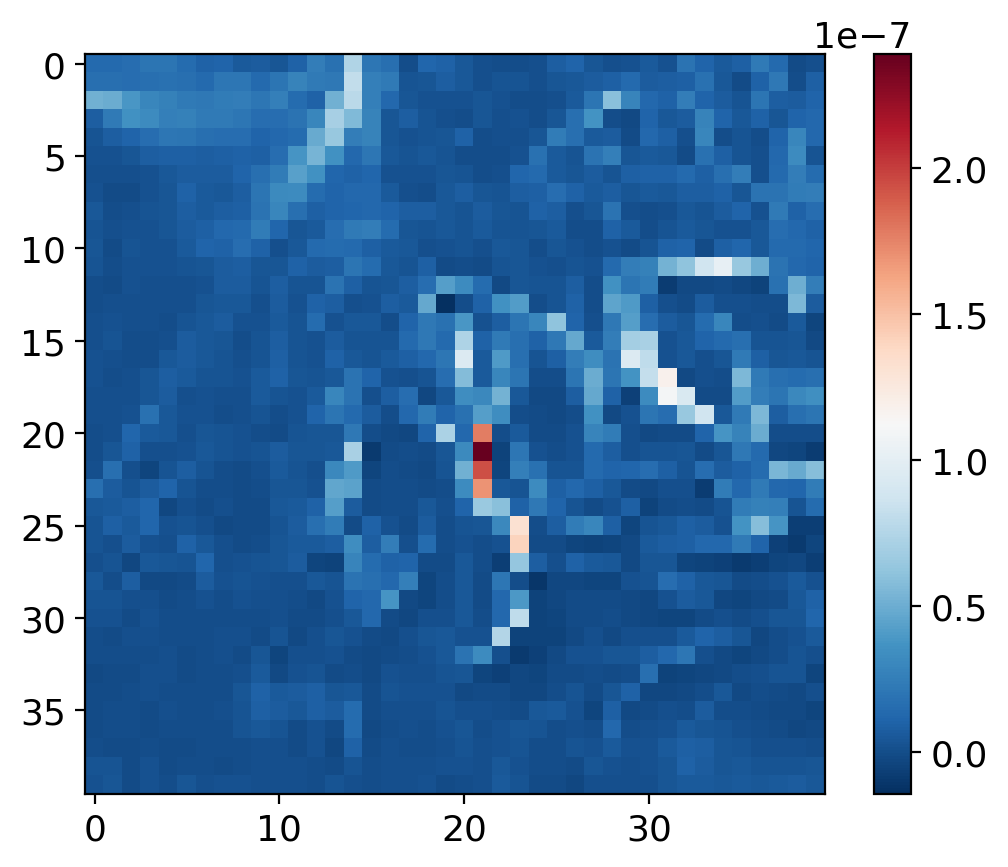

In [79]:
# looking at a still ordered, non-normalized WB_sg_xr
plt.imshow(np.flip(WB_sg_og_xr.data[1],axis=0),cmap='RdBu_r')
#plt.imshow(np.flip(WB_sg_xr.data[1],axis=0),cmap='RdBu_r') for the normalized version.
plt.colorbar()